In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
import fibermodes as fm
from scipy.interpolate import interp1d

# this makes all fonts in the plot Arial
matplotlib.rc('font', family='Arial')
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### my functions

font = {'family': 'Arial', 'size': 10}

colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow',
      'brown', 'pink', 'teal', 'lime', 'gray', 'olive', 'navy', 'salmon', 'gold']

# simulation parameters
lam = 1.0e-6
n_core = 1.55
n_clad = 1.46
r_core = 5e-6

### <span style="color: blue;"> Test 01: simulation of starting package</span>
The next cell is the starting package used by the group to learn how to find modes. The *fibermodes* modules calculates this value correctly. The correct value is neff = 1.548309855519153.

In [2]:
factory = fm.FiberFactory()
factory.addLayer(name="core", radius=r_core, material="Fixed", geometry="StepIndex", index=n_core)
factory.addLayer(name="cladding", material="Fixed", index=n_clad)

fiber = factory[0]
neff = fiber.neff(fm.Mode(fm.ModeFamily.HE, 1, 1), lam)
print(neff) 

1.5483098555191532


### <span style="color: blue;"> Test 02: Number of modes and cut-off behavior</span>
The next cell calculates all modes for the given configuration and wavelength. It correctly predicts single-mode fiber and also correctly shows the number of modes very close to the cut-off.
An important point is that EH(0,x) and TE(0,x) modes give the same effective index as they should (tested). The code does not find an effective index value for HE(0,1) mode, which is ok since one can use TM(0,1). It works for all other combinations of HE(0,x) and TM(0,x).  

In [3]:
import pandas as pd
V = 2*np.pi*r_core/lam*np.sqrt((n_core)**2 - (n_clad)**2)
print("waveguide parameter:\t\t"+str(V))
print("single-mode value:\t\t2.4048255576957728")

factory = fm.FiberFactory()
factory.addLayer(name="core", radius=r_core, material="Fixed", geometry="StepIndex", index=n_core)
factory.addLayer(name="cladding", material="Fixed", index=n_clad)

fiber = factory[0]
modes = fiber.findVmodes(lam)
# print(modes)

modes = [
    ('TE', 0, 1), ('EH', 0, 1), ('TE', 0, 2), ('EH', 0, 2),
    ('TM', 0, 1), ('TM', 0, 2), ('HE', 0, 2)
]

data = [
    (f"{family}{m}{n}", fiber.neff(fm.Mode(getattr(fm.ModeFamily, family), m, n), lam))
    for family, m, n in modes
]

df = pd.DataFrame(data, columns=['Mode', 'Effective Index (neff)'])

display(df)

waveguide parameter:		16.351378633788386
single-mode value:		2.4048255576957728


,Mode,Effective Index (neff)
0,TE01,1.545736
1,EH01,1.545736
2,TE02,1.535696
3,EH02,1.535696
4,TM01,1.545683
5,TM02,1.535526
6,HE02,1.535526


### <span style="color: blue;"> Test 03: dispersion calculation</span>
The next cell defined all the relevant functions. In particular, it defines the function to find the effective index of a selected mode for a given fiber and wavelength. No dispersion is assumed in simulations.

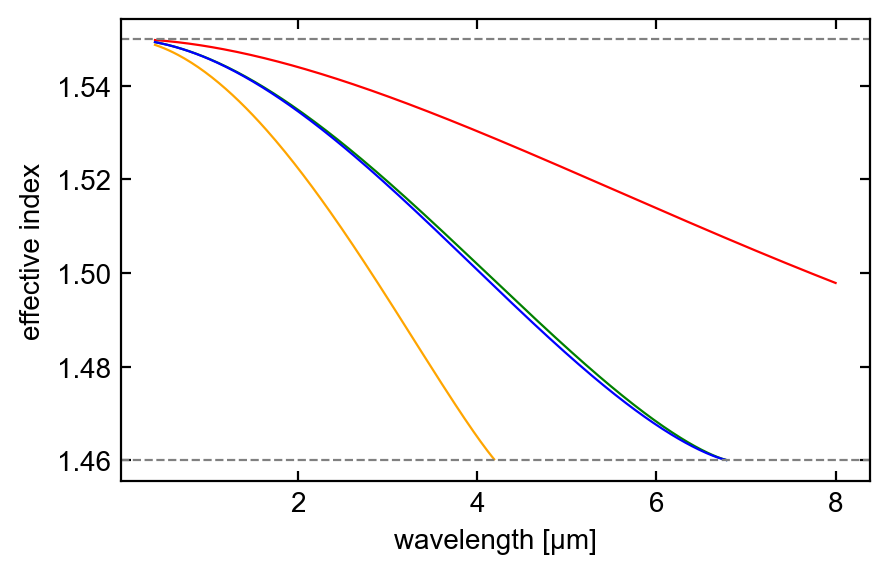

In [4]:
def find_neff_mode(lam, r_co, n_co, n_cl, mode_family, m, l):
    factory = fm.FiberFactory()
    factory.addLayer(name="core", radius=r_co, material="Fixed", geometry="StepIndex", index=n_co)
    factory.addLayer(name="cladding", material="Fixed", index=n_cl)
    fiber = factory[0]
    mode = fm.Mode(mode_family, m, l)
    neff = fiber.neff(mode, lam)
    return neff

m_lam = np.linspace(0.4e-6, 8.0e-6, 300)

m_neff_HE11 = [find_neff_mode(lam, r_core, n_core, n_clad, fm.ModeFamily.HE, 1, 1) for lam in m_lam]
m_neff_TE01 = [find_neff_mode(lam, r_core, n_core, n_clad, fm.ModeFamily.TE, 0, 1) for lam in m_lam]
m_neff_TM01 = [find_neff_mode(lam, r_core, n_core, n_clad, fm.ModeFamily.TM, 0, 1) for lam in m_lam]
m_neff_HE21 = [find_neff_mode(lam, r_core, n_core, n_clad, fm.ModeFamily.HE, 3, 1) for lam in m_lam]

fig, ax = plt.subplots(1,1,figsize=(3*1.61, 3))
ax.plot(m_lam/1e-6, m_neff_HE11, linewidth=0.8 ,color = colors[0])
ax.plot(m_lam/1e-6, m_neff_TE01, linewidth=0.8 ,color = colors[1])
ax.plot(m_lam/1e-6, m_neff_TM01, linewidth=0.8 ,color = colors[2])
ax.plot(m_lam/1e-6, m_neff_HE21, linewidth=0.8 ,color = colors[3])
ax.set_xlabel('wavelength [µm]')
ax.set_ylabel('effective index')
ax.axhline(y=n_core, color='gray', linestyle='--', label='core index', linewidth=0.8)
ax.axhline(y=n_clad, color='gray', linestyle='--', label='cladding index', linewidth=0.8)
plt.show()

### <span style="color: blue;"> Test 05: mode fields</span>
There is a strange behavior of the fundamental mode at r=0 that depends on the number of samples. Below are two examples of sample points N=200 and N=201. Also, the fundamental mode does not look correct.

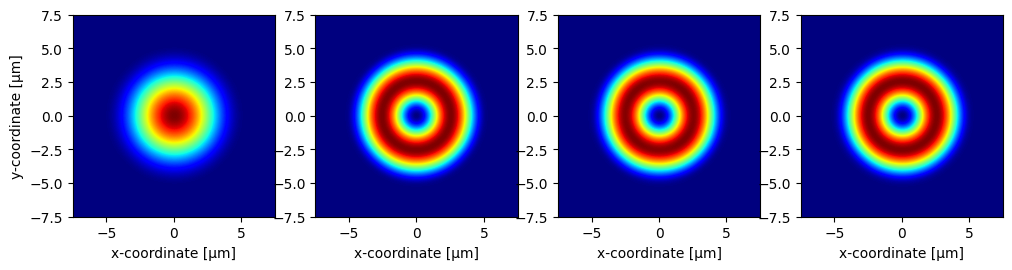

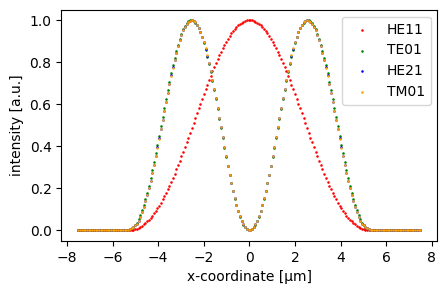

In [3]:
import numpy as np
from fibermodes import FiberFactory, Mode
from matplotlib import pyplot, pyplot as plt

lam = 1.0e-6
n_core = 1.55
n_clad = 1.46
r_core = 5e-6
N_sampling = 200
R_sim = 7.5e-6
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow',
      'brown', 'pink', 'teal', 'lime', 'gray', 'olive', 'navy', 'salmon', 'gold']

### definition of fiber
factory = FiberFactory()
factory.addLayer(name="core", radius=r_core, material="Fixed", geometry="StepIndex", index=n_core)
factory.addLayer(name="cladding", material="Fixed", index=n_clad)
fiber = factory[0]
modes_1 = Mode("HE", 1, 1)
modes_2 = Mode("TE", 0, 1)
modes_3 = Mode("TM", 0, 1)
modes_4 = Mode("HE", 2, 1)

### calculation of fields
field_HE11 = fiber.field(modes_1, lam, R_sim, N_sampling) #fm.field.Field(fiber, fm.Mode(fm.ModeFamily.HE, 1, 1), lam, R_sim, N_sampling)
field_TE01 = fiber.field(modes_2, lam, R_sim, N_sampling)
field_TM01 = fiber.field(modes_3, lam, R_sim, N_sampling)
field_HE21 = fiber.field(modes_4, lam, R_sim, N_sampling)

# sampling points: N_sampling = 200
def plot_2D_fields_intensity(field):
    field_Ex = field.Ex(0,0)
    field_Ey = field.Ey(0,0)
    # field_I = field_Ex**2 + field_Ey**2
    field_I = np.abs(field_Ex)**2 + np.abs(field_Ey)**2
    return field_I


HE11_int = plot_2D_fields_intensity(field_HE11)
TE01_int = plot_2D_fields_intensity(field_TE01)
HE21_int = plot_2D_fields_intensity(field_HE21)
TM01_int = plot_2D_fields_intensity(field_TM01)

R_sim_n = R_sim/1e-6
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(3*4, 3))
ax1.imshow(HE11_int, cmap='jet', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])
ax2.imshow(TE01_int, cmap='jet', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])
ax3.imshow(HE21_int, cmap='jet', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])
ax4.imshow(TM01_int, cmap='jet', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])

ax1.set_xlabel('x-coordinate [µm]')
ax2.set_xlabel('x-coordinate [µm]')
ax3.set_xlabel('x-coordinate [µm]')
ax1.set_ylabel('y-coordinate [µm]')
ax4.set_xlabel('x-coordinate [µm]')
plt.show()

s = 0.7
m_x = np.linspace(-R_sim, R_sim, N_sampling)
fig, ax = plt.subplots(1,1,figsize=(3*1.61803398875,3))
ax.scatter(m_x/1e-6, HE11_int[:,int(N_sampling/2)]/np.max(HE11_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[0], label = "HE11")
ax.scatter(m_x/1e-6, TE01_int[:,int(N_sampling/2)]/np.max(TE01_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[1], label = "TE01")
ax.scatter(m_x/1e-6, HE21_int[:,int(N_sampling/2)]/np.max(HE21_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[2], label = "HE21")
ax.scatter(m_x/1e-6, TM01_int[:,int(N_sampling/2)]/np.max(TM01_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[3], label = "TM01")
ax.set_xlabel('x-coordinate [µm]')
ax.set_ylabel('intensity [a.u.]')
ax.legend(loc='upper right')
plt.show()

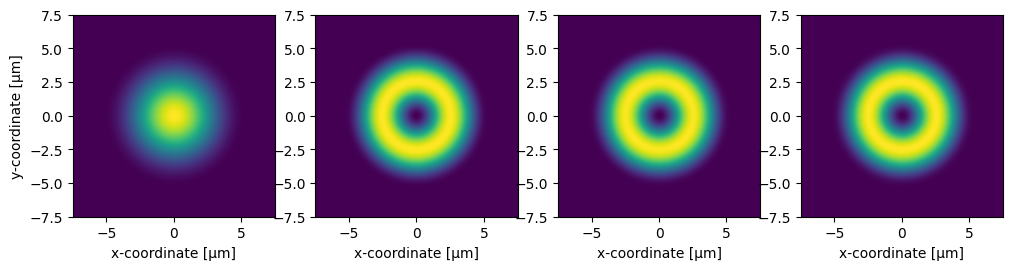

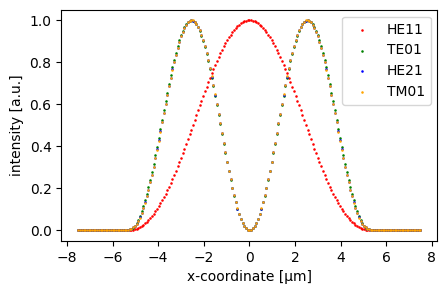

In [4]:
import numpy as np
from fibermodes import FiberFactory, Mode
from matplotlib import pyplot, pyplot as plt

lam = 1.0e-6
n_core = 1.55
n_clad = 1.46
r_core = 5e-6
N_sampling = 201
R_sim = 7.5e-6
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow',
      'brown', 'pink', 'teal', 'lime', 'gray', 'olive', 'navy', 'salmon', 'gold']

### definition of fiber
factory = FiberFactory()
factory.addLayer(name="core", radius=r_core, material="Fixed", geometry="StepIndex", index=n_core)
factory.addLayer(name="cladding", material="Fixed", index=n_clad)
fiber = factory[0]
modes_1 = Mode("HE", 1, 1)
modes_2 = Mode("TE", 0, 1)
modes_3 = Mode("TM", 0, 1)
modes_4 = Mode("HE", 2, 1)

### calculation of fields
field_HE11 = fiber.field(modes_1, lam, R_sim, N_sampling) #fm.field.Field(fiber, fm.Mode(fm.ModeFamily.HE, 1, 1), lam, R_sim, N_sampling)
field_TE01 = fiber.field(modes_2, lam, R_sim, N_sampling)
field_TM01 = fiber.field(modes_3, lam, R_sim, N_sampling)
field_HE21 = fiber.field(modes_4, lam, R_sim, N_sampling)

# sampling points: N_sampling = 200
def plot_2D_fields_intensity(field):
    field_Ex = field.Ex(0,0)
    field_Ey = field.Ey(0,0)
    # field_I = field_Ex**2 + field_Ey**2
    field_I = np.abs(field_Ex)**2 + np.abs(field_Ey)**2
    return field_I


HE11_int = plot_2D_fields_intensity(field_HE11)
TE01_int = plot_2D_fields_intensity(field_TE01)
HE21_int = plot_2D_fields_intensity(field_HE21)
TM01_int = plot_2D_fields_intensity(field_TM01)

R_sim_n = R_sim/1e-6
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(3*4, 3))
ax1.imshow(HE11_int, cmap='viridis', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])
ax2.imshow(TE01_int, cmap='viridis', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])
ax3.imshow(HE21_int, cmap='viridis', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])
ax4.imshow(TM01_int, cmap='viridis', extent=[-R_sim_n, R_sim_n, -R_sim_n, R_sim_n])

ax1.set_xlabel('x-coordinate [µm]')
ax2.set_xlabel('x-coordinate [µm]')
ax3.set_xlabel('x-coordinate [µm]')
ax1.set_ylabel('y-coordinate [µm]')
ax4.set_xlabel('x-coordinate [µm]')
plt.show()

s = 0.7
m_x = np.linspace(-R_sim, R_sim, N_sampling)
fig, ax = plt.subplots(1,1,figsize=(3*1.61803398875,3))
ax.scatter(m_x/1e-6, HE11_int[:,int(N_sampling/2)]/np.max(HE11_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[0], label = "HE11")
ax.scatter(m_x/1e-6, TE01_int[:,int(N_sampling/2)]/np.max(TE01_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[1], label = "TE01")
ax.scatter(m_x/1e-6, HE21_int[:,int(N_sampling/2)]/np.max(HE21_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[2], label = "HE21")
ax.scatter(m_x/1e-6, TM01_int[:,int(N_sampling/2)]/np.max(TM01_int[:,int(N_sampling/2)]),s=s,lw = 1,color = colors[3], label = "TM01")
ax.set_xlabel('x-coordinate [µm]')
ax.set_ylabel('intensity [a.u.]')
ax.legend(loc='upper right')
plt.show()

### <span style="color: blue;"> Test 06: vector fields</span>
The EH01 mode is not correct, as it should be the same as the TE01-mode.

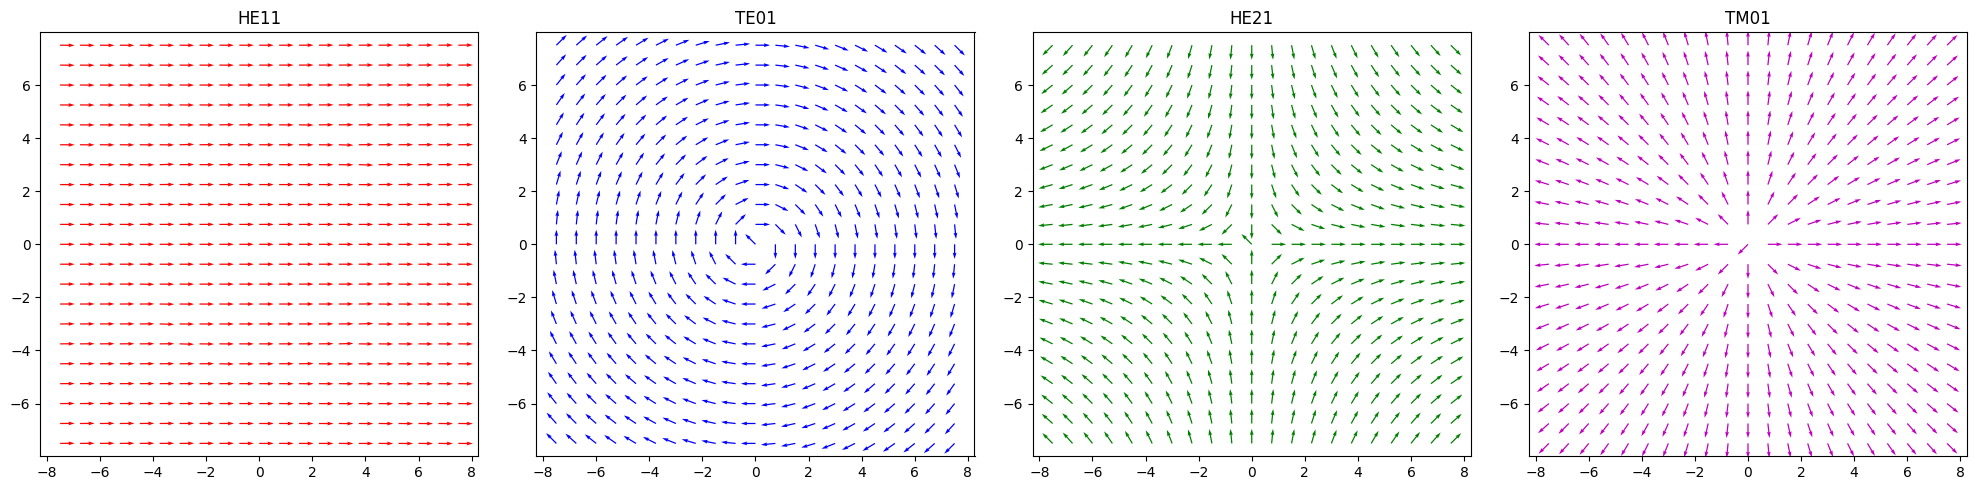

In [5]:
# Field Polarization
HE11_pol= field_HE11.Epol(0, 0)
TE01_pol = field_TE01.Epol(0, 0)
HE21_pol = field_HE21.Epol(0, 0)
TM01_pol = field_TM01.Epol(0, 0)

# Downsampling
downsampling = 10
mode_int_down_HE11 = HE11_int[::downsampling, ::downsampling]
mode_pol_down_HE11 = HE11_pol[::downsampling, ::downsampling]

mode_int_down_TE01 = TE01_int[::downsampling, ::downsampling]
mode_pol_down_TE01 = TE01_pol[::downsampling, ::downsampling]

mode_int_down_HE21 = HE21_int[::downsampling, ::downsampling]
mode_pol_down_HE21 = HE21_pol[::downsampling, ::downsampling]

mode_int_down_TM01 = TM01_int[::downsampling, ::downsampling]
mode_pol_down_TM01 = TM01_pol[::downsampling, ::downsampling]

# Sampling Grid
N_sampling_down = len(mode_int_down_HE11)
x = np.linspace(-R_sim_n, R_sim_n, N_sampling_down)
y = np.linspace(-R_sim_n, R_sim_n, N_sampling_down)
X, Y = np.meshgrid(x, y)

# Vector Field Calculations
U_HE11 = np.cos(mode_pol_down_HE11)
V_HE11 = np.sin(mode_pol_down_HE11)

U_TE01 = np.cos(mode_pol_down_TE01)
V_TE01 = np.sin(mode_pol_down_TE01)

U_HE21 = np.cos(mode_pol_down_HE21)
V_HE21 = np.sin(mode_pol_down_HE21)

U_TM01 = np.cos(mode_pol_down_TM01)
V_TM01 = np.sin(mode_pol_down_TM01)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# HE11 Plot
axes[0].quiver(X, Y, U_HE11, V_HE11, scale=30, color='r')
axes[0].set_title('HE11')
axes[0].axis('equal')

# TE01 Plot
axes[1].quiver(X, Y, U_TE01, V_TE01, scale=30, color='b')
axes[1].set_title('TE01')
axes[1].axis('equal')

# EH01 Plot
axes[2].quiver(X, Y, U_HE21, V_HE21, scale=30, color='g')
axes[2].set_title('HE21')
axes[2].axis('equal')

# TM01 Plot
axes[3].quiver(X, Y, U_TM01, V_TM01, scale=30, color='m')
axes[3].set_title('TM01')
axes[3].axis('equal')

plt.tight_layout()
plt.show()
